# Péter és a farkas: Valósághű környezet

A mi helyzetünkben Péter szinte fáradtság és éhség nélkül tudott mozogni. Egy valósághűbb világban időnként le kell ülnie pihenni, és ennie is kell. Tegyük világunkat valósághűbbé az alábbi szabályok bevezetésével:

1. Amikor Péter egyik helyről a másikra mozog, **energiát** veszít és **fáradtságot** szerez.
2. Péter több energiát nyerhet, ha almát eszik.
3. Péter megszabadulhat a fáradtságtól, ha pihen a fa alatt vagy a füvön (azaz olyan mezőre lép, ahol fa vagy fű van - zöld terület).
4. Péternek meg kell találnia és meg kell ölnie a farkast.
5. Ahhoz, hogy Péter legyőzze a farkast, bizonyos szintű energiával és fáradtsággal kell rendelkeznie, különben elveszíti a csatát.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

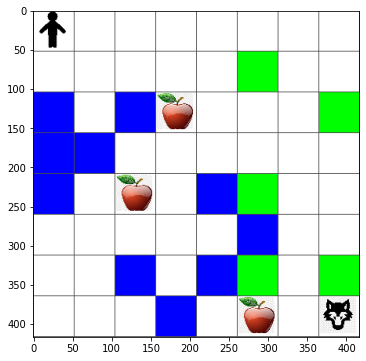

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Állapot meghatározása

Az új játékszabályok szerint nyomon kell követnünk az energiát és a fáradtságot minden táblázati állapotban. Ezért létrehozunk egy `state` objektumot, amely tartalmazza az aktuális problémaállapotról szükséges összes információt, beleértve a tábla állapotát, az aktuális energiaszinteket és fáradtságot, valamint azt, hogy legyőzhetjük-e a farkast a végállapotban:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Próbáljuk megoldani a problémát véletlenszerű sétával, és nézzük meg, sikerül-e:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Jutalomfüggvény

A jutalomfüggvény az egyik legfontosabb elem a megerősítéses tanulásban. Ez határozza meg, hogy az ügynök milyen visszajelzést kap a cselekedeteiért, és közvetlenül befolyásolja a tanulási folyamatot.

### Miért fontos a jutalomfüggvény?

A jutalomfüggvény célja, hogy az ügynököt a kívánt viselkedés felé irányítsa. Ha a jutalomfüggvény túl egyszerű vagy rosszul van megtervezve, az ügynök nem biztos, hogy a kívánt eredményt éri el. Másrészt, egy jól megtervezett jutalomfüggvény segíthet az ügynöknek hatékonyan megtanulni a feladatot.

[!NOTE] A jutalomfüggvény megtervezése gyakran iteratív folyamat, amely próbálkozást és finomhangolást igényel.

### Példa egy egyszerű jutalomfüggvényre

Az alábbi példa egy egyszerű jutalomfüggvényt mutat be, amely egy ügynököt arra ösztönöz, hogy elérjen egy célt:

```python
def reward_function(state, action):
    if state == "goal":
        return 1  # Jutalom a cél eléréséért
    else:
        return -0.1  # Büntetés minden más állapotért
```

Ebben a példában az ügynök jutalmat kap, ha eléri a célt, és enyhe büntetést kap minden más állapotért. Ez arra ösztönzi az ügynököt, hogy a lehető leggyorsabban elérje a célt.

### Gyakori hibák a jutalomfüggvények tervezésében

1. **Túlzottan bonyolult jutalomfüggvények**: Ha a jutalomfüggvény túl bonyolult, az ügynök nehezen tanulhatja meg, hogy mely cselekedetek vezetnek a kívánt eredményhez.
2. **Nem megfelelő büntetések vagy jutalmak**: Ha a büntetések vagy jutalmak aránytalanok, az ügynök nem biztos, hogy a kívánt viselkedést tanulja meg.
3. **Nem egyértelmű célok**: Ha a jutalomfüggvény nem tükrözi egyértelműen a célokat, az ügynök összezavarodhat.

[!TIP] Mindig teszteld a jutalomfüggvényt különböző forgatókönyvekben, hogy biztosítsd, hogy az ügynök a kívánt viselkedést tanulja meg.

### Összefoglalás

A jutalomfüggvény kulcsszerepet játszik az ügynök tanulási folyamatában. Egy jól megtervezett jutalomfüggvény segíthet az ügynöknek gyorsabban és hatékonyabban elérni a célokat. Mindig szánj időt a jutalomfüggvény alapos megtervezésére és tesztelésére!


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algoritmus

A tényleges tanulási algoritmus szinte változatlan marad, csak a `state`-et használjuk ahelyett, hogy csak a tábla pozícióját használnánk.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

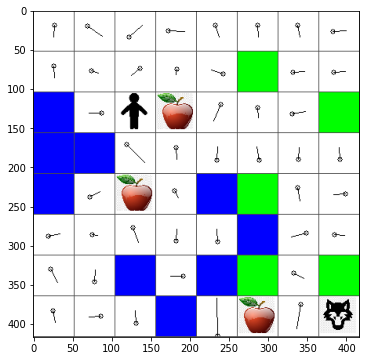

In [11]:
m.plot(Q)

## Eredmények

Nézzük meg, sikerült-e Pétert megtanítani, hogyan küzdjön meg a farkassal!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Most már sokkal kevesebb fulladásos esetet látunk, de Péter még mindig nem mindig képes megölni a farkast. Próbálj kísérletezni, és nézd meg, hogy javíthatod-e ezt az eredményt a hiperparaméterekkel való játékkal.


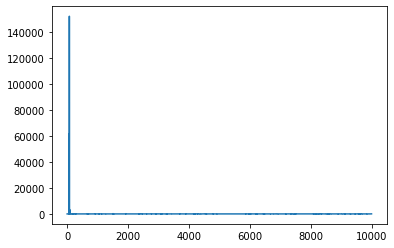

In [13]:
plt.plot(lpath)


---

**Felelősségkizárás**:  
Ez a dokumentum az [Co-op Translator](https://github.com/Azure/co-op-translator) AI fordítási szolgáltatás segítségével lett lefordítva. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt professzionális, emberi fordítást igénybe venni. Nem vállalunk felelősséget a fordítás használatából eredő félreértésekért vagy téves értelmezésekért.
